# Emotion Recognition Project

In [1]:
# mounting the drive and importing from my drive to git
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive
!git clone https://github.com/marius2347/emotion-recognition.git


Mounted at /content/drive
/content/drive/MyDrive
fatal: destination path 'emotion-recognition' already exists and is not an empty directory.


# 1. Libraries

In [8]:
import os, random, math, time
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
!nvidia-smi
!pip -q install torchmetrics==1.4.0 scikit-learn==1.5.1

Thu Aug 14 13:34:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 2. Load the dataset with images and labels

In [12]:
# train path
train_dir = '/content/drive/MyDrive/emotion-recognition/train'
test_dir = '/content/drive/MyDrive/emotion-recognition/test'
val_dir = ''
os.chdir(train_dir)
print(f"Current directory: {os.getcwd()}")
print("Train exists:", os.path.isdir(train_dir))
print("Val   exists:", os.path.isdir(val_dir))
print("Test  exists:", os.path.isdir(test_dir))

Current directory: /content/drive/MyDrive/emotion-recognition/train
Train exists: True
Val   exists: False
Test  exists: True


In [4]:
# emotion labels paths
emotion_subfolders = [f.name for f in os.scandir('.') if f.is_dir()]
print("Emotion subfolders found:", emotion_subfolders)

Emotion subfolders found: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


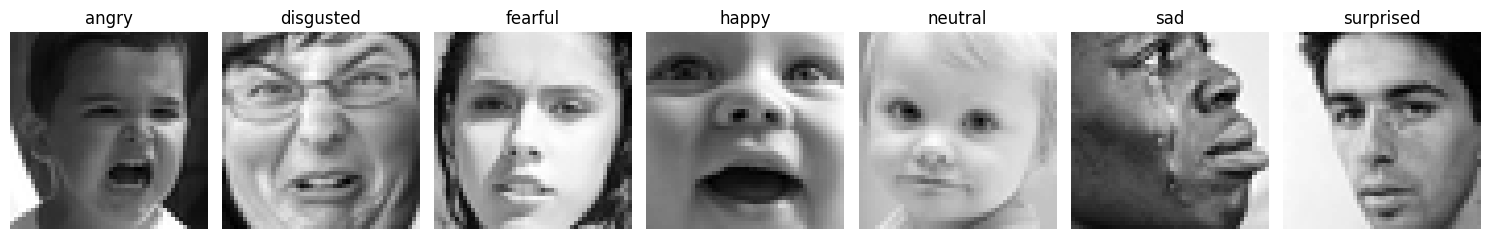

In [5]:
# images and labels
plt.figure(figsize=(15, 5))

for i, emotion in enumerate(emotion_subfolders):
    emotion_path = os.path.join(train_dir, emotion)

    image_files = [f for f in os.listdir(emotion_path) if os.path.isfile(os.path.join(emotion_path, f))]
    if image_files:
        first_image_path = os.path.join(emotion_path, image_files[0])
        img = mpimg.imread(first_image_path)

        plt.subplot(1, len(emotion_subfolders), i + 1)

        plt.imshow(img, cmap='gray')
        plt.title(emotion)
        plt.axis('off')
    else:
        print(f"No images found in {emotion_path}")

plt.tight_layout()
plt.show()

# 3. Get ready for training

In [11]:
# check for gpu and set a seed for reproductibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')